<a href="https://colab.research.google.com/github/srikrish2812/info621_project/blob/main/src/notebooks/gemma_3_final_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gemma 3 — Inference

## Framework/ Library Installation

In [ ]:
%%capture
# Installs unsloth and other dependencies optimized for colab
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --upgrade transformers accelerate bitsandbytes datasets asteval GPUtil

In [ ]:
# Imports
import os
import re
import pdb

from tqdm import tqdm
import unsloth
from unsloth import FastLanguageModel
from datasets import load_dataset

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Use helper functions from repository

colab = True
if colab:
  if not os.path.exists("info621/"):
    !git clone https://github.com/srikrish2812/info621_project info621

Cloning into 'info621'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 101 (delta 40), reused 55 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (101/101), 614.27 KiB | 14.29 MiB/s, done.
Resolving deltas: 100% (40/40), done.


## Load the final model and dataset

In [ ]:
def load_model():
  """
  Load the trained Gemma 3 1B with Unsloth.
  """
  model_name = "abhay2812/gemma-3-1b-4bit-grpo"
  model, tokenizer = FastLanguageModel.from_pretrained(
      model_name,
      load_in_4bit=True,
      device_map="auto"
  )
  FastLanguageModel.for_inference(model)

  return model, tokenizer

model, tokenizer = load_model()

==((====))==  Unsloth 2025.4.8: Fast Gemma3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

In [ ]:
from info621.src.tasks.gsm8k import GSM8kTask
# from gsm8k import GSM8kTask


gsm8k = GSM8kTask()
dataset = gsm8k.get_questions()

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

## Inference
- Run inference with final model on random sample from the test dataset.

In [ ]:
from transformers import TextStreamer

In [ ]:
sample = dataset['train'].select([0])
sample['prompt']

[[{'content': '\n<start_of_turn>user\nSolve the following math problem step-by-step:\n{question}<end_of_turn>\n<start_of_turn>model\n',
   'role': 'system'},
  {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?',
   'role': 'user'}]]

In [ ]:
def run_model(sample, measure_p=False, max_new_tokens=256):
  text = tokenizer.apply_chat_template(
      sample,
      add_generation_prompt = True,
      tokenize = False,
  )
  streamer = TextStreamer(tokenizer, skip_prompt=True)

  if measure_p:
    streamer = None

  tensor = model.generate(
      **tokenizer(text, return_tensors = "pt").to("cuda"),
      max_new_tokens = max_new_tokens,
      temperature = 1.0, top_p = 0.95, top_k = 64,
      streamer = streamer,
  )
  return tensor

In [ ]:
model_output = run_model(sample['prompt'], measure_p=False)

Let $C$ be the number of clips Natalia sold in April.
Let $M$ be the number of clips Natalia sold in May.

Natalia sold clips to 48 friends in April. So, $C = 48$.
In May, she sold half as many clips as in April. So, $M = \frac{1}{2} \times C = \frac{1}{2} \times 48 = 24$.

The total number of clips sold in April and May is $C + M = 48 + 24 = 72$.

Thus, Natalia sold 72 clips altogether in April and May.

Final Answer: The final answer is $\boxed{72}$<end_of_turn>


In [ ]:
decoded_output = tokenizer.decode(model_output[0])
y = gsm8k.extract_answer(decoded_output)
sample['answer'][0] == y

True

In [ ]:
print("Code demonstration finished!")

## Measure Gemma 3 Performance — Latency  on NVIDIA® T4 GPU
Latency refers to the time it takes for a model to output a response based on the input. The output of LLMs has a couple possibilities: streaming or non-streaming mode. They effectively impact user experience and are crucial in developing AI applications.

There are a few key metrics that define latency, that differ between streaming and non-streaming modes.

1. Time to first token (TTFT): The TTFT represents how your application starts responding. It's the amount of time from when the user submits a query until a certain threshold is reached (i.e., first token, word, or chunk). Other variants include Time to last token (TTLT). The response time is affected by several factors:
  - Length of input prompt
  - Network conditions and geographic locations
  - **Calculation:** Time to first token - Time from query submission
  - Interpretation: lower is better

2. End-to-end latency (E2E): E2E latency measures the overall time time to complete the response. Key factors that impact the response time:
  - Length of input prompt
  - Requested amount length
  - Maximum amount of tokens the model produces
  - Complexity of the task
  - **Calculation:** Time at completion of request - Time from query submission
  - Interpretation: lower is better.

Warmup is shown to improve latency, therefore we each metric is evaluated with warmup.




In [ ]:
import time
import GPUtil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def test_latency(sample, iterations=1, warmup=False, max_new_tokens=256):
  if warmup:
    for _ in range(5):
      random_sample = gsm8k.__getsamples__(n_samples=1, split="train")
      _ = run_model(random_sample['prompt'], measure_p=True, max_new_tokens=max_new_tokens)

  latencies = []
  gpus = GPUtil.getGPUs()

  if not gpus:
    raise ValueError("No GPUs found.")
  gpu = gpus[0]

  for _ in range(iterations):
    start_time = time.time()
    _ = run_model(sample['prompt'], measure_p=True, max_new_tokens=max_new_tokens)
    end_time = time.time()
    latencies.append(end_time-start_time)

  return latencies

In [ ]:
def test_eval_latency(latencies, iterations=100):
  print(f"Average latencies per {iterations} iterations: {np.mean(latencies):.4f} seconds")
  print(f"Maximum latency per {iterations} iterations: {np.max(latencies):.4f} seconds")
  print(f"Minimum latency per {iterations} iterations: {np.min(latencies):.4f} seconds")

In [ ]:
def convert_to_milliseconds(vector):
  return np.array(vector) * 1000

Find the interval of tokens length in the training set of the dataset.
- The baseline number of tokens is 20.
- The interval is between 44 and 245 tokens.
- There will be 30 trials (iterations) for each token length with a step size of 25 tokens.

In [ ]:
def tokenizer_(x):
  return {"input_ids": tokenizer.apply_chat_template(x['prompt'], add_generation_prompt=True,tokenize=True)}

def length(x):
  return {"length": len(x['input_ids'])}

In [ ]:
dataset_map = dataset.map(tokenizer_)
dataset_map = dataset_map.map(length)
pd_dataset = dataset_map['train'].to_pandas()

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
intervals = [44, 70, 95, 120, 145, 170, 194, 219, 245] # token length intervals

In [ ]:
indices = []
for interval in intervals:
  sample_space = pd_dataset[pd_dataset['length'] == interval]
  indices.append(sample_space.sample().index[0])

1. Measure baseline latencies and evaluate.

In [ ]:
measure_latency = True
iterations = 30

In [ ]:
baseline_prompt = "Hello, world."

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": baseline_prompt}
]

baseline_msg = {"prompt": messages}

In [ ]:
if measure_latency:
  print("BASELINE_TTFT_WARMUP")
  baseline_ttft_warmup = test_latency(baseline_msg, iterations=iterations, warmup=True, max_new_tokens=1)
  test_eval_latency(baseline_ttft_warmup)

BASELINE_TTFT_WARMUP
Average latencies per 100 iterations: 0.1200 seconds
Maximum latency per 100 iterations: 0.1411 seconds
Minimum latency per 100 iterations: 0.1127 seconds


In [ ]:
if measure_latency:
  print("BASELINE_E2E_WARMUP")
  baseline_e2e_warmup = test_latency(baseline_msg, iterations=iterations, warmup=True, max_new_tokens=256)
  test_eval_latency(baseline_e2e_warmup)

BASELINE_E2E_WARMUP
Average latencies per 100 iterations: 3.3308 seconds
Maximum latency per 100 iterations: 11.0804 seconds
Minimum latency per 100 iterations: 1.2852 seconds


1. Measure time to first token and evaluate.

In [ ]:
if measure_latency:
  latencies_ttft = {}
  for idx in tqdm(indices):
    random = dataset['train'].select([idx])
    ttft_warmup = test_latency(random, iterations=iterations, warmup=True, max_new_tokens=1)
    latencies_ttft[idx] = {"warmup": ttft_warmup}

100%|██████████| 9/9 [00:42<00:00,  4.74s/it]


In [ ]:
data = []

for i,v in latencies_ttft.items():
  data.append(convert_to_milliseconds(v['warmup']))

Create a line plot to visualize the TTFT latency.

In [ ]:
def create_boxplot(data, y, configs):
  fig, ax = plt.subplots(figsize=(10, 5))

  ax.set_title(configs['title'])
  ax.set_xlabel(configs['xlabel'])
  ax.set_ylabel(configs['ylabel'])
  ax.yaxis.grid(color='white')
  ax.set_facecolor(color='gainsboro')
  bp = ax.boxplot(data, patch_artist=True, tick_labels=y, boxprops=configs['boxprops'])
  plt.tight_layout()
  plt.savefig(configs['png'])
  return plt.show()

In [ ]:
ttft_configs = {}
ttft_configs['title'] = 'Gemini 1B 4bit Latency for Time to First Token (TTFT)'
ttft_configs['xlabel'] = f"Prompt Tokens with {iterations} Trials"
ttft_configs['ylabel'] = 'Latency (milliseconds)'
ttft_configs['boxprops'] = dict(facecolor="tab:blue")
ttft_configs['png'] = 'ttft.png'

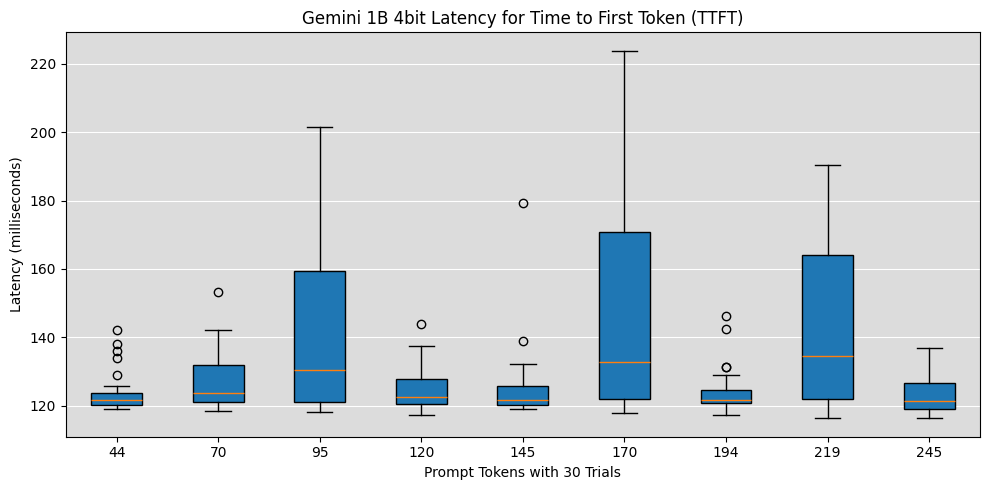

In [ ]:
create_boxplot(data, intervals, ttft_configs)

2. Measure end-to-end latency.

In [ ]:
if measure_latency:
  latencies_e2e = {}
  for idx in tqdm(indices):
    random = dataset['train'].select([idx])
    e2e_warmup = test_latency(random, iterations=iterations, warmup=True, max_new_tokens=256)
    latencies_e2e[idx] = {"warmup": e2e_warmup}

100%|██████████| 9/9 [1:52:24<00:00, 749.42s/it]


In [ ]:
data = []

for i,v in latencies_e2e.items():
  data.append(v['warmup'])

Visualize the e2e latencies.

In [ ]:
e2e_configs = {}
e2e_configs['title'] = 'Gemini 1B 4bit Latency for End-to-End (E2E) Completion'
e2e_configs['xlabel'] = f"Prompt Tokens with {iterations} Trials"
e2e_configs['ylabel'] = 'Latency (seconds)'
e2e_configs['boxprops'] = dict(facecolor="tab:purple")
e2e_configs['png'] = "e2e.png"

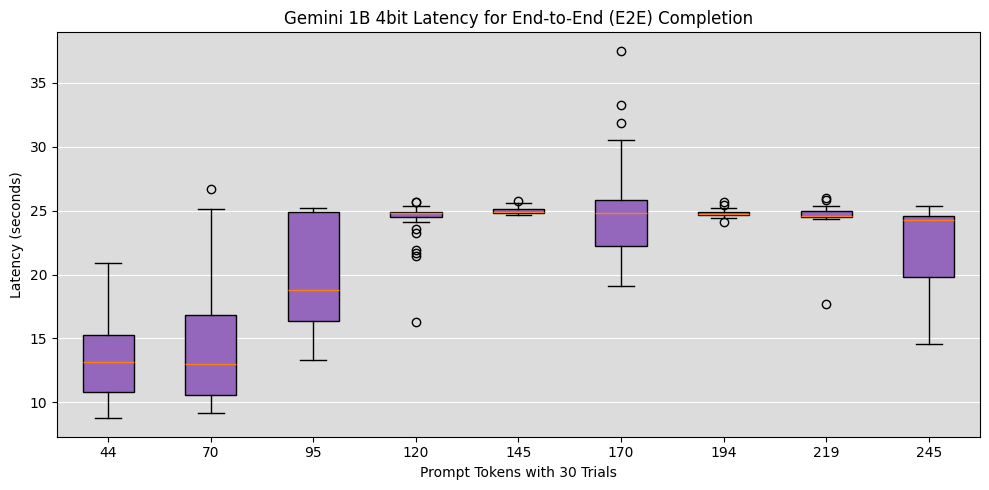

In [ ]:
create_boxplot(data, intervals, e2e_configs)